## Get Image Location
### Alexandra Higley and Nick Byrnes
Modified from Nick Byrnes' "CRAB-Optics" (https://github.com/drailin/CRAB-optics)
<br>
<br>

A program so I don't have to figure out where S2 is over and over again. 

For the installation of the TPC camera, we need to know where the image will be so we know where to put the image intensifier. We can find this location using the lens maker equation. The program calculates it based on input variables. 

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib import cm

### Functions and Constants

Sellmeier equation for different materials to find index of refraction at varied wave-length. The function takes input of wavelength and material to find index of refraction for your lens. Current options include:

- MgF2 
- CaF2
- UVFS. 

For the TPC camera project, we are using a CaF2 lens. More materials can be added if need be. Index of refraction is calculated below, but it is squared. square root if need regular n 

In [2]:
def index_ref(wavelength, material):
    if material == 'MgF2':
        n_sqr = (1 
               + 0.48755108*wavelength**2/(wavelength**2-0.04338408**2) 
               + 0.39875031*wavelength**2/(wavelength**2-0.09461442**2) 
               + 2.3120353*wavelength**2/(wavelength**2-23.793604**2) )
        
    elif material == 'CaF2':
        n_sqr = (1 
               + 0.33973 
               + 0.69913*wavelength**2/(wavelength**2-0.09374**2) 
               + 0.11994*wavelength**2/(wavelength**2-21.18**2) 
               + 4.35181*wavelength**2/(wavelength**2-38.46**2) )
        
    elif material == 'UVFS':
        n_sqr = (1 
               + 0.6961663*wavelength**2/(wavelength**2-0.0684043**2) 
               + 0.4079426*wavelength**2/(wavelength**2-0.1162414**2) 
               + 2.8974794*wavelength**2/(wavelength**2-9.896161**2) )

    return n_sqr

Lens Makers Equation for finding focal length at varied refractive index. roc1 and roc2 are the respective radii of curvature for each face of the lens. roc2 is infinite for a plano-convex or plano-concave lens, so the Lens Maker's eqution becomes quite simple for us as most of it goes to zero.

It should be noted that this equation does not take into consideration the thickness of the lens. The term in the Lens Maker's equation that includes thickness goes to zero when roc2 is infinite, although I do believe that the thickness of the lens will stll affect where the image is. As far as I can tell though, it will only be affect it on the scale of a few millimeters. 

- im_loc
 - takes parameter **foc_len** which is the focal length. This is either given or calculated.
 - takes parameter **s1**, which is the distance from the object being observed to the lens.
         
- get_foc
 - calculates focal length if it is not given, or if you have a varied wavelength (which will result in a varied index of refreaction. 
 - takes parameter **in_ref**, which is the index of refraction. This is determined by the material used. See above
 - takes parameter **roc1**, which is the first radius of curvature. This should be a paramter specified by the lens supplier. For a plano-convex or plano-concave lens, the second radius of curvature is infinite so it does not matter for us. 
<br>
<br>
- get_mag
 - calculates magnification without varied wavelength. 
 - takes parameters **s1** and **s2**, which are the distances from the object to the lens (s1) and the lens to the image (s2). The image intensifer shoudl be put where the image is formed
- get_height
 - finds height of the image created without varied wavelength
 - takes parameters **h_obj**, which is the height of the object (the EL regsion for us), and **mag** which is the magnification (see get_mag).

In [3]:
#only for plano-convex or plano-concave lenses
def im_loc(foc_len, s1):
    s2 = ((1/foc_len) - (1/s1))**-1
    return s2

def get_foc(in_ref, roc1):
    f_inv = (in_ref - 1)*(1/roc1)
    foc = (f_inv)**-1
    return foc


def get_mag(s1, s2):
    mag = -(s2/s1)
    return mag

def get_height(h_obj, mag):
    height_im = mag*h_obj
    return height_im

Constants for the TPC camera project:
(note that some of these constants were found under *LA5210* in https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=4354&pn=LA5210)

- vessel: 1219.2 mm
- door: 77.77 mm
- window: 33.34 mm
<br>
<br>
- 2 inch lens tube: 50.8 mm
- 1 inch lens tube: 25.4 mm
- 2 inch lens tube glued to vessel: 54.69 mm
- lens holder: 2.58 mm
- lens thickness: 11.2 mm
- middle of lens: 5.6 mm
- radius of curvature one: 43.4 mm
<br>
<br>
- measured to back of lens holder: 42.5 mm
- to back of lens: 45.08 mm
- to center of lens: 50.68 mm
<br>
<br>
- About the height of EL region: 400 mm

### If wavelength is not varied

In [4]:
height_ob = 400

#Not lens tube
vessel = 1219.2 
door = 77.79
window = 33.34
vessel_tot = vessel + door + window

#lens tube
glue_2lens = 54.69
cent_lens = 50.68
dist_to_lens = glue_2lens - cent_lens # estimate


s1_f = vessel_tot + dist_to_lens
s2_f = im_loc(100, s1_f)

mag = get_mag(s1_f, s2_f)
height_im = get_height(height_ob, mag)

print("S2 will be " + str(round(s2_f,3)) + " mm: put image intensifier there.")
print("The magnification will be " + str(round(mag,3)) + " mm.")
print("The height of the image created will be " + str(round(height_im,3)) + " mm.")

S2 will be 108.101 mm: put image intensifier there.
The magnification will be -0.081 mm.
The height of the image created will be -32.406 mm.


### If wavelength is varied

More constants for varied wavelengths. We want to be working in Xenon, if we can buy it, which scintillates in UV to optical, however as of right now we only have access or Argon gas which scintillates in UV.

These ranges are more of a loose guess than anything. Especially Argon

In [5]:
# Wavelengths in um (Sellmeier equation uses um usually)
wl_range_Xe = np.arange(0.1, 1.1, 0.001)
wl_range_Ar = np.arange(0.1, 0.325, 0.0001)

# Converts wavelength into nm, more intuitive for me.
wl_range_Xe_nm = wl_range_Xe*1000 
wl_range_Ar_nm = wl_range_Ar*1000 

# Lens
mat = 'CaF2' # Materials include: MgF2, CaF2, UVFS as of now.
R_1 = 43.4 # Radius of Curvature one 

Takes a list of wavelengths and calculates for each the refractive index of MgF2, focal length of a 28.3mm ROC lens, the needed distance between the lens and II, and the magnification .

- n_range --> indexes of refraction with varied wavelength
- f_range --> focal length with varied wavelength 
- d_i_range --> lens to II distance with varied wavelength
- m_range --> magnification with varied wavelength 
- h_range --> height of image on the II

For now, the only wavelength ranges I have are that for Xenon and Argon. We can note that Argon stays in the UV spectrun, whereas Xenon covers UV, optical, and even some IR. This is why we want xenon, so we can see the scintillation (in optical). 

Note that the magnification is negative and the height of the image is originally negative (I multiply it by negative one here). That is because the image will be upsidedown. 

In [6]:
#Xenon
n_range_Xe = []
for wl in wl_range_Xe:
    n_range_Xe.append(np.sqrt(index_ref(wl, mat)))
    
f_range_Xe = []
for n in n_range_Xe:
    f_range_Xe.append(get_foc(n, R_1))

d_i_range_Xe = []
for foc in f_range_Xe:
    d_i_range_Xe.append(im_loc(foc, vessel_tot))
    
m_range_Xe = []    
for d in d_i_range_Xe:
    m_range_Xe.append(-d/vessel_tot)
    # d is negative because the image will be flipped 
    
h_range_Xe = []
for m in m_range_Xe:
    h_range_Xe.append((height_ob*m)*-1)



#Argon     
n_range_Ar = []
for wl in wl_range_Ar:
    n_range_Ar.append(np.sqrt(index_ref(wl, mat)))
    
f_range_Ar = []
for n in n_range_Ar:
    f_range_Ar.append(get_foc(n, R_1))

d_i_range_Ar = []
for foc in f_range_Ar:
    d_i_range_Ar.append(im_loc(foc, vessel_tot))
    
m_range_Ar = []    
for d in d_i_range_Ar:
    m_range_Ar.append(-d/vessel_tot)
    # d is negative because the image will be flipped 

h_range_Ar = []
for m in m_range_Ar:
    h_range_Ar.append((height_ob*m)*-1)

Points of interest can also be found. For my project, I would like to know the information at the wavelength where Argon and Xenon electroluminate. For Argon, it is 127nm. For Xenon, it is about 175nm, however I marked all the wavelengths that were tested during the vacuum test (172nm, 175nm, 178nm)

In [7]:
#Xenon points of interest
poi_wl_172_loc = np.where((wl_range_Xe_nm > 171.5) & (wl_range_Xe_nm < 173)) #where it is 172 nm
poi_wl_175_loc = np.where((wl_range_Xe_nm > 174.5) & (wl_range_Xe_nm < 176)) #where it is 175 nm
poi_wl_178_loc = np.where((wl_range_Xe_nm > 177.5) & (wl_range_Xe_nm < 179)) #where it is 178 nm


#Argon point of interest
poi_wl_127_loc = np.where((wl_range_Ar_nm >= 127) & (wl_range_Ar_nm < 127.1)) #where it is 127 nm

In [8]:
d_i_range_Xe_arr = np.array(d_i_range_Xe)
m_range_Xe_arr = np.array(m_range_Xe)
h_range_Xe_arr = np.array(h_range_Xe)

d_i_range_Ar_arr = np.array(d_i_range_Ar)
m_range_Ar_arr = np.array(m_range_Ar)
h_range_Ar_arr = np.array(h_range_Ar)

#Wavelengths
wl_172 = wl_range_Xe_nm[poi_wl_172_loc]
wl_175 = wl_range_Xe_nm[poi_wl_175_loc]
wl_178 = wl_range_Xe_nm[poi_wl_178_loc]
wl_127 = wl_range_Ar_nm[poi_wl_127_loc]

#Lens to II Distance
d_i_172 = d_i_range_Xe_arr[poi_wl_172_loc]
d_i_175 = d_i_range_Xe_arr[poi_wl_175_loc]
d_i_178 = d_i_range_Xe_arr[poi_wl_178_loc]
d_i_127 = d_i_range_Ar_arr[poi_wl_127_loc]

#Magnification
m_172 = m_range_Xe_arr[poi_wl_172_loc]
m_175 = m_range_Xe_arr[poi_wl_175_loc]
m_178 = m_range_Xe_arr[poi_wl_178_loc]
m_127 = m_range_Ar_arr[poi_wl_127_loc]

#Image Height
h_172 = h_range_Xe_arr[poi_wl_172_loc]
h_175 = h_range_Xe_arr[poi_wl_175_loc]
h_178 = h_range_Xe_arr[poi_wl_178_loc]
h_127 = h_range_Ar_arr[poi_wl_127_loc]

print(wl_172)
print(d_i_172)
print(d_i_175)
print(d_i_178)
print(d_i_127)

print(len(wl_range_Xe_nm))
print(len(d_i_range_Xe_arr))

[172.]
[87.64594226]
[88.47076073]
[89.24911235]
[65.44733205]
1000
1000


### Plots

Now I will plot some of the data. Here I am plotting the lens to image intensifier distance, magnfication and image height as it changes with a varied wavelength. 

In [9]:
w1_175_lab = (str(wl_175)[0:4])
d_i_175_lab = (str(d_i_175)[1:6])
m_175_lab = (str(m_175)[1:6])
h_175_lab = (str(h_175)[1:6])

w1_127_lab = (str(wl_127)[0:4])
d_i_127_lab = (str(d_i_127)[1:6])
m_127_lab = (str(m_175)[1:6])
h_127_lab = (str(h_175)[1:6])

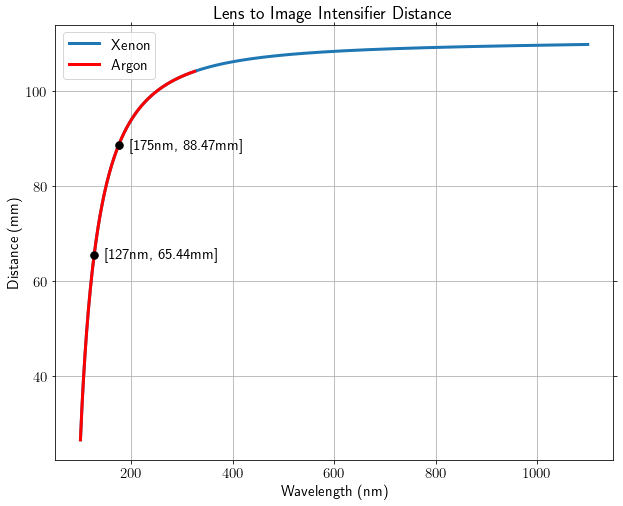

In [10]:
matplotlib.rc('text',usetex=True)
matplotlib.rc('font',size=15)
fig1,ax1 = plt.subplots(figsize=(10,8))

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Distance (mm)')

ax1.plot(wl_range_Xe_nm, d_i_range_Xe, label="Xenon", color="tab:blue", linewidth=3)
ax1.plot(wl_range_Ar_nm, d_i_range_Ar, label="Argon", color="r", linewidth=3)

pois_x = np.array([wl_127, wl_175])
pois_y = np.array([d_i_127, d_i_175])

ax1.scatter(pois_x, pois_y, color="black")
ax1.plot(wl_175, d_i_175, marker=".", markersize=15, color="black")
ax1.plot(wl_127, d_i_127, marker=".", markersize=15, color="black")

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)


annotations=[(".  \t" + w1_127_lab + "nm, " + d_i_127_lab + "mm]"), (".  \t" + w1_175_lab + "nm, " + d_i_175_lab + "mm]")]

for i, label in enumerate(annotations):
    plt.annotate(label, (pois_x[i], pois_y[i]), ha='left', va='center')

plt.legend()
plt.grid(True)
ax1.set_title("Lens to Image Intensifier Distance");

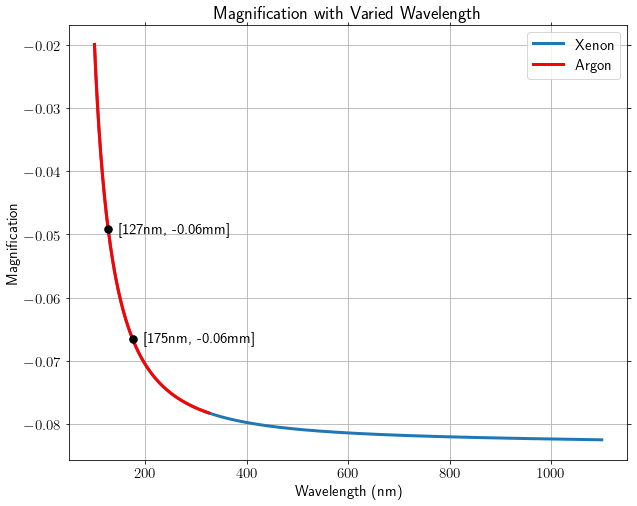

In [15]:
matplotlib.rc('text',usetex=True)
matplotlib.rc('font',size=15)
fig1,ax1 = plt.subplots(figsize=(10,8))

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Magnification')

ax1.plot(wl_range_Xe_nm, m_range_Xe, label="Xenon", color="tab:blue", linewidth=3)
ax1.plot(wl_range_Ar_nm, m_range_Ar, label="Argon", color="r", linewidth=3)

pois_x = np.array([wl_127, wl_175])
pois_y = np.array([m_127, m_175])

ax1.scatter(pois_x, pois_y, color="black")
ax1.plot(wl_175, m_175, marker=".", markersize=15, color="black")
ax1.plot(wl_127, m_127, marker=".", markersize=15, color="black")

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)


annotations=[(".  \t" + w1_127_lab + "nm, " + m_127_lab ), (".  \t" + w1_175_lab + "nm, " + m_175_lab + "mm]")]

for i, label in enumerate(annotations):
    plt.annotate(label, (pois_x[i], pois_y[i]), ha='left', va='center')

plt.legend()
plt.grid(True)
ax1.set_title("Magnification with Varied Wavelength");

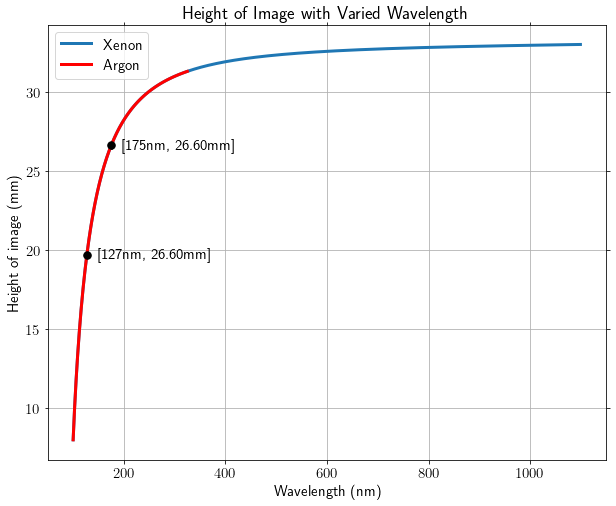

In [16]:
matplotlib.rc('text',usetex=True)
matplotlib.rc('font',size=15)
fig1,ax1 = plt.subplots(figsize=(10,8))

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Height of image (mm)')

ax1.plot(wl_range_Xe_nm, h_range_Xe, label="Xenon", color="tab:blue", linewidth=3)
ax1.plot(wl_range_Ar_nm, h_range_Ar, label="Argon", color="r", linewidth=3)

pois_x = np.array([wl_127, wl_175])
pois_y = np.array([h_127, h_175])

ax1.scatter(pois_x, pois_y, color="black")
ax1.plot(wl_175, h_175, marker=".", markersize=15, color="black")
ax1.plot(wl_127, h_127, marker=".", markersize=15, color="black")

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)


annotations=[(".  \t" + w1_127_lab + "nm, " + h_127_lab + "mm]"), (".  \t" + w1_175_lab + "nm, " + h_175_lab + "mm]")]

for i, label in enumerate(annotations):
    plt.annotate(label, (pois_x[i], pois_y[i]), ha='left', va='center')

plt.legend()
plt.grid(True)
ax1.set_title("Height of Image with Varied Wavelength");